# Gaze vector estimation and visualization

This notebook is a reference to _Paper: gaze estimation using a camera-based model in a classroom_ for running preliminary analysis on a webcam.
To run this notebook, a built-in webcam and good lighting is required. Meanwhile, some operating systems may require additional firewall settings to gain camera access. We make use of opencv's library to perform video processing and analysis for prelimninary tests on gaze capture.

Our gaze estimation application can be sectioned into:
 - Data pre-processing (face and eye detection)
 - Head pose classifiers (Euler angles: 𝛼,𝜃,𝜔) or reference plane
 - Attention boundary/matrix
 - Depth estimation function
 - Composition and visualization of gaze vector frequencies
Here, our model is primarily based on the relibility of our pre-trained face/eye detection(haarcascades). This dependency may undermine overall perfomance at scale. We aim to detect and identify multiple candidates in each frame of the image in order to estimate head and iris orientation.

## Display video files
A sample video input stream for opening video files and obtaining frame properties

In [ ]:
from cv2 import cv2
import os

videopath = '../data/glasses.mp4'
video = cv2.VideoCapture(videopath)
while video.isOpened():
    ret, frame = video.read()
    cv2.imshow('frame', frame)
    """fps = video.get(cv2.CAP_PROP_FPS)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    timestamp = video.get(cv2.CAP_PROP_POS_MSEC)"""
    if cv2.waitKey(25)== ord('q'):
        video.release()
        cv2.destroyAllWindows()
        break

# Face and eye detection
We detect each faces per frame using the _frontal view haarcascade classifier_. Gaze vector is a function of the eye coordinates relative to its' reference plane **RP** (which is addressed in Section 2). Afterwards, the face frame object is passed to the eye classifier. In the following two cells, we extract faces and iris coordinates shown in bounding boxes.

In [2]:
#We create our library dependecies and global variables for our little test algorithm for a face and eye tracker
import cv2, time, os
import PIL.Image
from IPython.display import clear_output
import numpy as np
import dlib
import matplotlib.pyplot as plt

print(os.getcwd())
path01 = '../data/haarcascades'
path02 = "../iris-tracker-by-contours/shape_predictor_68_face_landmarks.dat"

#We create our pre-trained cascade objects for face and eye
f = "haarcascade_frontalface_default.xml"
e = "haarcascade_eye.xml"
le = "haarcascade_lefteye_2splits"
re = "haarcascade_righteye_2splits"

face_cascade = cv2.CascadeClassifier(os.path.join(path,f))
eye_cascade = cv2.CascadeClassifier(os.path.join(path,e))
le_cascade = cv2.CascadeClassifier(os.path.join(path,le))
re_cascade = cv2.CascadeClassifier(os.path.join(path,re))

/Users/Neo/Documents/Documents - lars’s MacBook Pro/Thesis Project/notebooks


In [ ]:
import dlib
import time
import cv2
import numpy as np
import numpy.linalg

In [2]:
vs = cv2.VideoCapture(0)
numerator=0
denominator=0

#Instantiate frontal face detector
face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../iris-tracker-by-contours/shape_predictor_68_face_landmarks.dat")

lStart, lEnd = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
rStart, rEnd = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

#We define a fun eye aspect ratio function EAR()
def EAR(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])

    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = np.linalg.norm(eye[0] - eye[3])

    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)

    # return the eye aspect ratio
    return ear

while True:
    _,frame = vs.read()
    roi = frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # detect dlib face rectangles
    faces = detector(gray, 0)

    for face in faces:
        eyes = []
        
        # convert dlib rect to a bounding box
        (x,y,w,h) = face_utils.rect_to_bb(face)
        
        # print(x,y,w,h)
        xc,yc = (x+w/2,y+h/2)
        radius = (w**2+h**2)**0.5
        
        #cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),1)
        cv2.circle(frame,(xc,yc), radius, (255,0,0), thickness=1)

        # get the landmarks from dlib, convert to np array
        shape = predictor(gray, face)
        shape = face_utils.shape_to_np(shape)
        
        # indexes for left and right eye key points
        leftEye = shape[lStart:lEnd]  
        rightEye = shape[rStart:rEnd]

        eyes.append(leftEye)  #wrap in a list
        eyes.append(rightEye)
        
        # save the state of both eyes to print
        both_eyes_state = []

        # loop through both eyes
        for index, eye in enumerate(eyes):

            eye_EAR = eye_aspect_ratio(eye)

            single_eye_state = []  # first entry is eye index, second entry is the closed or eye direction state

            left_side_eye = eye[0]  # left edge of eye
            right_side_eye = eye[3]  # right edge of eye
            top_side_eye = eye[1]  # top side of eye
            bottom_side_eye = eye[4]  # bottom side of eye

            # calculate height and width of dlib eye keypoints
            eye_width = right_side_eye[0] - left_side_eye[0]
            eye_height = bottom_side_eye[1] - top_side_eye[1]

            # create bounding box with buffer around keypoints
            eye_x1 = int(left_side_eye[0] - 0 * eye_width)  # .25 works well too
            eye_x2 = int(right_side_eye[0] + 0 * eye_height)  # .75 works well too

            eye_y1 = int(top_side_eye[1] - 1 * eye_height)
            eye_y2 = int(bottom_side_eye[1] + 1 * eye_height)

            # draw bounding box around eye roi
            cv2.rectangle(frame,(eye_x1, eye_y1), (eye_x2, eye_y2),(0,255,0),2)

            # draw the circles for the eye landmarks
            for i in eye:
                cv2.circle(frame, tuple(i), 3, (0, 0, 255), -1)

        #------------ estimation of distance of the human from camera--------------#
            # d=10920.0/float(w)

            roi = frame[eye_y1:eye_y2,eye_x1:eye_x2]

            #  ---------    check if eyes open   -------------  #

            # state is open/close, or direction looking
            eye_state = None

            if eye_EAR > 0.25:

                #  ---------    find center of pupil   -------------  #

                gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)  # grey scale convert
                blur = cv2.medianBlur(gray,5) # blue image to find the iris better
                equ = cv2.equalizeHist(blur)  # ie, improve contrast by spreading the range over the same window of intensity
                thres=cv2.inRange(equ,0,15)  # threshold the contour edges, higher number means more will be black
                kernel = np.ones((3,3),np.uint8)  # placeholder

            #     #/------- removing small noise inside the white image ---------/#
                dilation = cv2.dilate(thres,kernel,iterations = 2)
            #     #/------- decreasing the size of the white region -------------/#
                erosion = cv2.erode(dilation,kernel,iterations = 3)
            #     #/-------- finding the contours -------------------------------/#
                image, contours, hierarchy = cv2.findContours(erosion,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            #     #--------- checking for 2 contours found or not ----------------#

                pupil_found = None

                if len(contours)==2 :
                    # print('2 contours found')
                    pupil_found = True

                    img = cv2.drawContours(roi, contours, 1, (0,255,0), 3)
                    #------ finding the centroid of the contour ----------------#
                    M = cv2.moments(contours[1])

                    if M['m00']!=0:
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                        cv2.line(roi,(cx,cy),(cx,cy),(0,0,255),3)
                        # print(cx,cy)
                #-------- checking for one contour present --------------------#

                if len(contours)==1:
                    pupil_found = True
                    # print('only 1 contour found ------- ')

                    img = cv2.drawContours(roi, contours, 0, (0,255,0), 3)

                    #------- finding centroid of the contour ----#
                    M = cv2.moments(contours[0])
                    if M['m00']!=0:
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                        # print(cx,cy)
                        cv2.line(roi,(cx,cy),(cx,cy),(0,0,255),3)

                if pupil_found:
                    # find ratio of distance from each side of the eye bounding box
                    # to get quantify direction of pupil

                    width_ratio = cx / eye_width
                    height_ratio = cy / (eye_y2 - eye_y1)  # make sure to use bounding box height

                    if (width_ratio < 0.4):
                        print('Looking right')
                        single_eye_state.append(index)
                        single_eye_state.append('Right')
                    elif (width_ratio > 0.6):
                        print('Looking left')
                        single_eye_state.append(index)
                        single_eye_state.append('Left')
                    elif (height_ratio < 0.35):
                        print('Looking up')
                        single_eye_state.append(index)
                        single_eye_state.append('Up')
                    else:
                        print('Looking forward')
                        single_eye_state.append(index)
                        single_eye_state.append('Forward')

                # eyes are opened, but pupils not found
                else:
                    print('Pupil not found')
                    single_eye_state.append(index)
                    single_eye_state.append('No pupil found')

                # doens't really work because it appears eyes are closed when
                # looking down
                # if (height_ratio > 0.50):
                #     print('Looking down')

            # if height / width < 0.3, then eye is closed, or person is looking down
            else:
                single_eye_state.append(index)
                single_eye_state.append('Closed')

            # end loop for one eye
            both_eyes_state.append(single_eye_state)

        # end loop for one face
        # write state for both eyes

        for ind, eye in enumerate(both_eyes_state):
            # print(eye)
            eye_num = ['Left', 'Right']
            # text = 'Hello'
            text = '{} eye is looking:  {}'.format(eye_num[ind], eye[1])

            cv2.putText(frame, text, (50, 50*(ind+1)), \
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

    cv2.imshow("frame",frame)
    # if the `q` key was pressed, break from the loop
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
vs.release()
# print("accurracy=",(float(numerator)/float(numerator+denominator))*100)
cv2.destroyAllWindows()

NameError: name 'face_utils' is not defined

In [ ]:
#We create our eye class which contain our eye coordinates
class Eye():
    def __init__(self,x, y, x2, y2):
        self.x = x
        self.y = y
        self.x2 = x2
        self.y2 = y2
        self.width = x2 - x
        self.height = y2 - y
        self.topcorner = (x, y)
        self.bottomcorner = (x2, y2)

def detect_eyes(image, classifierObject_e):
    eyes = classifierObject_e.detectMultiScale(image)
    right_eye = None
    left_eye = None
    
    if eyes is not None:
        for eye in eyes:
            x, y = (eye[0], eye[1])
            x2, y2 = (eye[0]+eye[2], eye[1] + eye[3])
            
            if right_eye is None:
                right_eye = Eye(x,y,x2,y2)
                continue
            else:
                left_eye = Eye(x,y,x2,y2)
                break
    return right_eye, left_eye

In [6]:

cap = cv2.VideoCapture(0)
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.flip(frame,1)

    #We read each image from the stream and convert to gray scale 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #I used these to tune the input image over intensity thresholds with some built-in cv2 functions
    """
    edged = cv2.Canny(gray, 30, 200)
    thresh = cv2.threshold(blurred,60, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((5,5), np.uint8)
    dilate = cv2.dilate(thresh.copy(), kernel, iterations = 2)
    """

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("../data/shape_predictor_68_face_landmarks.dat")

    #Returns a 1 X 4 array with bounding box coordinates(x, y , w, h) of detected faces of 
    #the image with scale factor
    faces = face_cascade.detectMultiScale(gray,1.5, 5)
    if faces is not None:
        for face in faces:
            x,y,w,h = face

            #Draw a rectantle around the face
            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),3)

            #Extract image of face
            face_frame = frame[x:x+w,y:y+h]

            #Detect eyes each face_frame
            eyes = detect_eyes(frame, eye_cascade)

            if eyes is not None:
                try:
                    cv2.rectangle(frame, eyes[0].topcorner, eyes[0].bottomcorner, (0,0,255),3)
                    cv2.rectangle(frame, eyes[1].topcorner, eyes[1].bottomcorner, (0,255,0),3)
                except AttributeError:
                    continue
            continue

    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
         break

# Release everything if job is finished
cap.release()
cv2.destroyAllWindows()


RuntimeError: Unexpected version found while deserializing dlib::shape_predictor.

## Head pose classifiers (Euler angles: 𝛼,𝜃,𝜔) or reference plane

In [8]:
#import boto3
#boto3.client('rekognition')
#boto3.client('kinesisvideo')

In [4]:
#Create our head orientation estimator which comprises of three mini-classifiers (𝛼,𝜃,𝜔)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models.layers import Dense, Dropout, Activation, Flatten, Convo2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

import pickle

model = Sequential()
model.add(Convo2D(image_shape, filters = ,kernel = (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2))

model.add(Convo2D(0.5*len(height)),(3,3))
model.add(Activation("relu"))
model.add(Maxpooling2D(pool_size=(2,2)))
          
model.add(Flatten())
model.add(Dense(32))
          
model.add(Dense(4))
model.add(Activation("sigmoid"))
          
model.compile(loss = "binary_crossentropy", 
              optimizer ="adam", 
              metrics =['accuracy'])
model.fit(x,y,bath_size = 32 ,validation_split =0.2)



SyntaxError: invalid syntax (<ipython-input-4-18395105c7f1>, line 14)

In [1]:
#Annotation module for extracting on-screen cursor coordinates for classifier labels

import pynput
from pynput.mouse import Button, Controller
mouse = Controller()
mouse.position = (10,20)
mouse.move(100,200)

ModuleNotFoundError: No module named 'pynput'

6*x
12.0


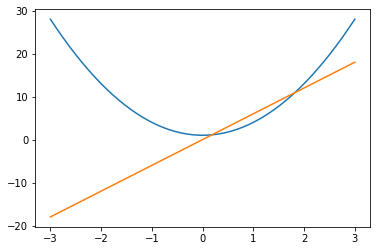

In [29]:
import sympy as sp
x = sp.Symbol('x')
print(sp.diff(3*x**2 + 1,x))

from scipy.misc import derivative
def f(x):
    return 3*x**2 + 1
print(derivative(f,2.0))

def d(x):
    return derivative(f,x)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

y = np.linspace(-3,3)
plt.plot(y,f(y))
plt.plot(y,d(y))

In [2]:
import dlib
help(dlib.get_frontal_face_detector)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor()

Help on built-in function get_frontal_face_detector in module dlib:

get_frontal_face_detector(...) method of builtins.PyCapsule instance
    get_frontal_face_detector() -> dlib::object_detector<dlib::scan_fhog_pyramid<dlib::pyramid_down<6u>, dlib::default_fhog_feature_extractor> >
    
    Returns the default face detector

